# Notebook 1: Localización de la región de interés (ROI)

1. Carga y exploración inicial del dataset
2. Preprocesado básico de las imágenes
3. Crear y guardar de un data frame limpo 

In [ ]:
import pandas as pd

import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

## Paso 1: Carga y exploración inicial del dataset

In [ ]:
csv_trazas = "REY_DATASET/traza_REY.csv"

# Cargamos el CSV sin header, usando ";" como delimitador
df_trazas = pd.read_csv(csv_trazas, sep=';', comment='#', header=None)

# Definimos manualmente los nombres de columnas según la documentación proporcionada
df_trazas.columns = ['id', 'fname', 'forig', 'BB', 'rot']

# Ahora limpiamos cada columna quitando prefijos y espacios innecesarios
for col in ['id', 'fname', 'forig', 'BB', 'rot']:
    df_trazas[col] = df_trazas[col].apply(lambda x: x.split(':', 1)[-1].strip())

# Mostramos el dataframe final limpio
print(df_trazas.head())
print("\nColumnas limpias:", df_trazas.columns.tolist())

In [ ]:
# Definir rutas (ajusta estas rutas según tu directorio)
path_imagenes_originales = "REY_DATASET/REY_scan_anonim"
path_roi = "REY_DATASET/REY_roi_rot0"

# Función para cargar imágenes
def cargar_imagen(nombre, path):
    ruta_completa = os.path.join(path, nombre)
    img = cv2.imread(ruta_completa)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

# Mostrar pares imagen original-ROI
num_imagenes = 5

fig, axs = plt.subplots(num_imagenes, 2, figsize=(12, 4 * num_imagenes))

for i in range(num_imagenes):
    registro = df_trazas.iloc[i]

    # Imagen original
    nombre_original = registro['forig']
    img_orig = cargar_imagen(nombre_original, path_imagenes_originales)

    # Imagen ROI
    nombre_roi = registro['fname']
    img_roi = cargar_imagen(nombre_roi, path_roi)

    # Visualización
    axs[i, 0].imshow(img_orig)
    axs[i, 0].set_title(f"Original: {nombre_original}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img_roi)
    axs[i, 1].set_title(f"ROI: {nombre_roi}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()




## Paso 2. Preprocesado básico de las imágenes

### Objetivo del preprocesado:
* Convertir todas las imágenes al mismo tamaño.
* Aplicar normalización estándar para mejorar la convergencia del modelo CNN.
* (Opcionalmente) Aplicar técnicas sencillas de detección de bordes para ayudar al modelo a aprender patrones geométricos.

In [ ]:
# Parámetros
IMAGE_SIZE = (256, 256)

# Rutas ajustadas
path_imagenes_originales = "REY_DATASET/REY_scan_anonim"
path_roi = "REY_DATASET/REY_roi_rot0"

# Función para preprocesado sencillo (redimensionar y pasar a escala de grises)
def cargar_y_preprocesar_simple(ruta, nombre_archivo, size=IMAGE_SIZE):
    ruta_completa = os.path.join(ruta, nombre_archivo)
    img = cv2.imread(ruta_completa, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0  # normalización simple [0,1]
    return img

# Ejemplo visualización del nuevo preprocesado
num_ejemplos = 3

fig, axs = plt.subplots(num_ejemplos, 2, figsize=(10, 5 * num_ejemplos))

for i in range(num_ejemplos):
    registro = df_trazas.iloc[i]

    img_orig = cargar_y_preprocesar_simple(path_imagenes_originales, registro['forig'])
    img_roi = cargar_y_preprocesar_simple(path_roi, registro['fname'])

    axs[i, 0].imshow(img_orig, cmap='gray')
    axs[i, 0].set_title("Original preprocesada (gris)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img_roi, cmap='gray')
    axs[i, 1].set_title("ROI preprocesada (gris)")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Paso 3. Crear y guardar un dataframe limpio

### Identificar automáticamente índices con imágenes corruptas o inexistentes

In [ ]:
indices_a_eliminar = []

for idx, registro in df_trazas.iterrows():
    ruta_img_orig = os.path.join("REY_DATASET/REY_scan_anonim", registro['forig'])
    ruta_img_roi = os.path.join("REY_DATASET/REY_roi_rot0", registro['fname'])
    
    if not os.path.exists(ruta_img_orig) or not os.path.exists(ruta_img_roi):
        print(f"Imagen faltante en índice {idx}: {registro['forig']} o {registro['fname']}")
        indices_a_eliminar.append(idx)

print("Índices a eliminar:", indices_a_eliminar)

### Crear y almacenar un nuevo DataFrame limpio (sin las imágenes corruptas)

In [ ]:
df_trazas_limpio = df_trazas.drop(indices_a_eliminar).reset_index(drop=True)

print(f"Número total de muestras: {len(df_trazas_limpio)}")

In [ ]:
df_trazas_limpio.to_csv("df_trazas_limpio.csv", index=False)

## Análisis de las dimensiones de las imágenes

In [9]:
# Obtener información sobre las dimensiones de las imágenes
print("Análisis de dimensiones de imágenes:")
dimensiones_originales = []
dimensiones_roi = []

for idx, registro in df_trazas_limpio.iloc[:20].iterrows():  # Usar una muestra para no sobrecargarlo
    try:
        # Original
        ruta_img_orig = os.path.join(path_imagenes_originales, registro['forig'])
        img_orig = cv2.imread(ruta_img_orig, cv2.IMREAD_GRAYSCALE)
        if img_orig is not None:
            dimensiones_originales.append(img_orig.shape)
        
        # ROI
        ruta_img_roi = os.path.join(path_roi, registro['fname'])
        img_roi = cv2.imread(ruta_img_roi, cv2.IMREAD_GRAYSCALE)
        if img_roi is not None:
            dimensiones_roi.append(img_roi.shape)
    except:
        continue

print(f"Dimensiones mínimas (originales): {min(dimensiones_originales, key=lambda x: x[0]*x[1])}")
print(f"Dimensiones máximas (originales): {max(dimensiones_originales, key=lambda x: x[0]*x[1])}")
print(f"Dimensiones mínimas (ROI): {min(dimensiones_roi, key=lambda x: x[0]*x[1])}")
print(f"Dimensiones máximas (ROI): {max(dimensiones_roi, key=lambda x: x[0]*x[1])}")

Análisis de dimensiones de imágenes:
Dimensiones mínimas (originales): (825, 524)
Dimensiones máximas (originales): (847, 594)
Dimensiones mínimas (ROI): (200, 182)
Dimensiones máximas (ROI): (817, 523)


## Distribución de las rotactiones


Distribución de rotaciones:
rot
90     435
0      317
-90    104
180     30
         1
Name: count, dtype: int64


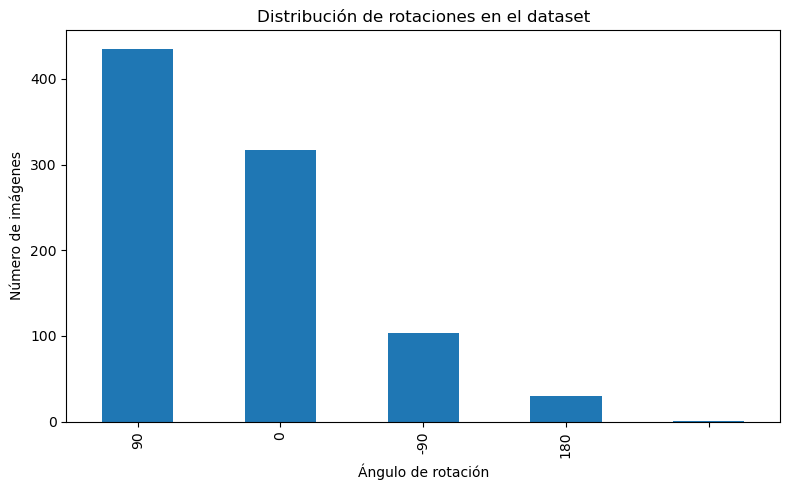

In [10]:
# Analizar la distribución de las rotaciones
rotaciones = df_trazas_limpio['rot'].value_counts()
print("\nDistribución de rotaciones:")
print(rotaciones)

# Visualizar la distribución
plt.figure(figsize=(8, 5))
rotaciones.plot(kind='bar')
plt.title('Distribución de rotaciones en el dataset')
plt.xlabel('Ángulo de rotación')
plt.ylabel('Número de imágenes')
plt.tight_layout()
plt.show()

## Análisis de Boundin boxes


Estadísticas de las bounding boxes:
Ancho medio: 373.36 píxeles
Altura media: 404.60 píxeles
Relación de aspecto media: 0.97


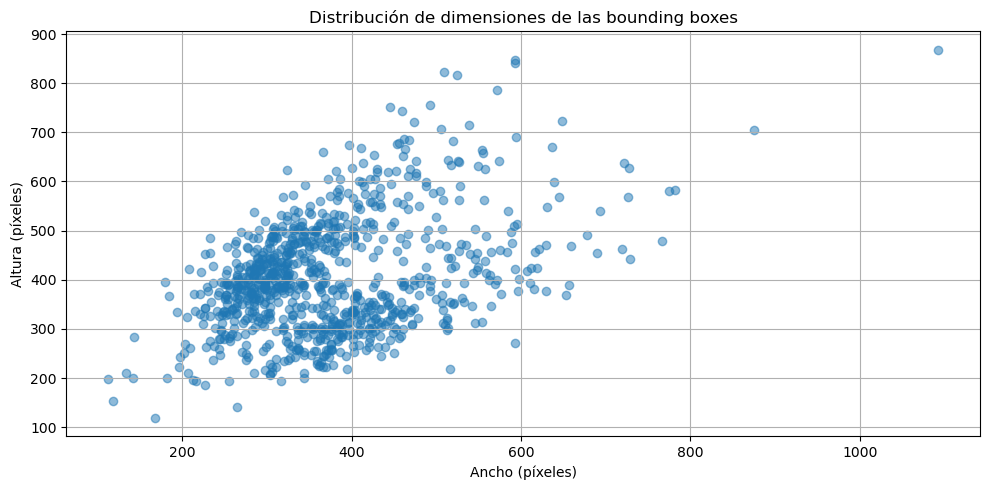

In [11]:
# Preprocesar las bounding boxes para análisis
df_trazas_limpio['BB_procesado'] = df_trazas_limpio['BB'].apply(
    lambda x: [int(coord) for coord in x.replace('[', '').replace(']', '').split(',')]
)

# Extraer componentes de las bounding boxes
df_trazas_limpio['x0'] = df_trazas_limpio['BB_procesado'].apply(lambda x: x[0])
df_trazas_limpio['y0'] = df_trazas_limpio['BB_procesado'].apply(lambda x: x[1])
df_trazas_limpio['altura'] = df_trazas_limpio['BB_procesado'].apply(lambda x: x[2])
df_trazas_limpio['ancho'] = df_trazas_limpio['BB_procesado'].apply(lambda x: x[3])

# Estadísticas de las bounding boxes
print("\nEstadísticas de las bounding boxes:")
print(f"Ancho medio: {df_trazas_limpio['ancho'].mean():.2f} píxeles")
print(f"Altura media: {df_trazas_limpio['altura'].mean():.2f} píxeles")
print(f"Relación de aspecto media: {(df_trazas_limpio['ancho'] / df_trazas_limpio['altura']).mean():.2f}")

# Visualizar la distribución de tamaños
plt.figure(figsize=(10, 5))
plt.scatter(df_trazas_limpio['ancho'], df_trazas_limpio['altura'], alpha=0.5)
plt.title('Distribución de dimensiones de las bounding boxes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Altura (píxeles)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Integridad de los datos

In [14]:
# Verificar integridad de los datos
def verificar_imagen(ruta):
    try:
        img = cv2.imread(ruta)
        if img is None:
            return False
        return True
    except:
        return False

# Conteo de archivos en los directorios
print("\nRecuento de archivos:")
print(f"Archivos en directorio original: {len(os.listdir(path_imagenes_originales))}")
print(f"Archivos en directorio ROI: {len(os.listdir(path_roi))}")
print(f"Filas en DataFrame: {len(df_trazas)}")
print(f"Filas en DataFrame limpio: {len(df_trazas_limpio)}")
print(f"Imágenes descartadas: {len(df_trazas) - len(df_trazas_limpio)}")


Recuento de archivos:
Archivos en directorio original: 888
Archivos en directorio ROI: 888
Filas en DataFrame: 889
Filas en DataFrame limpio: 887
Imágenes descartadas: 2


## Visualización de ejemplos con BB

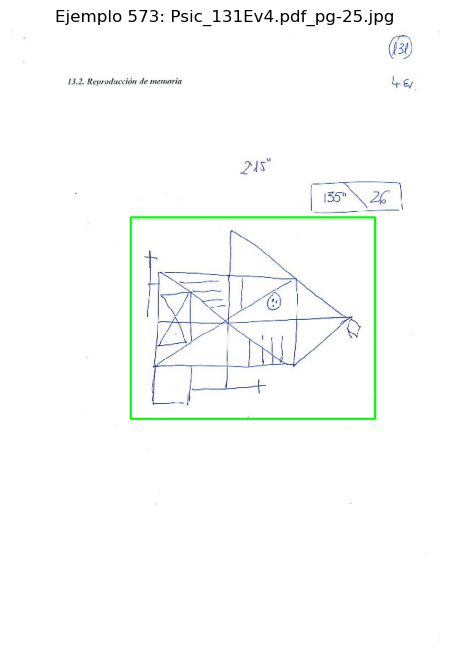

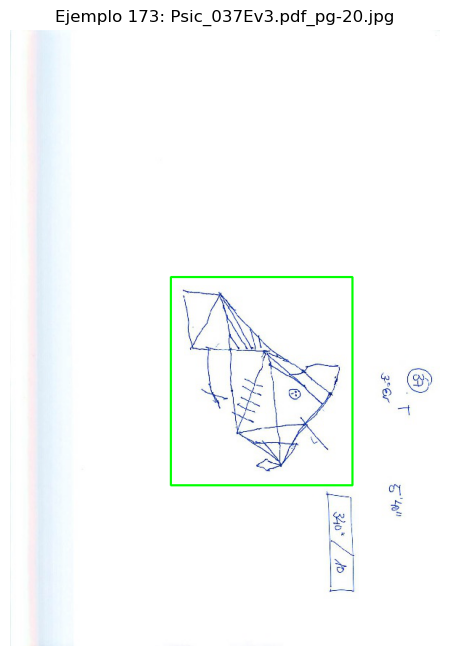

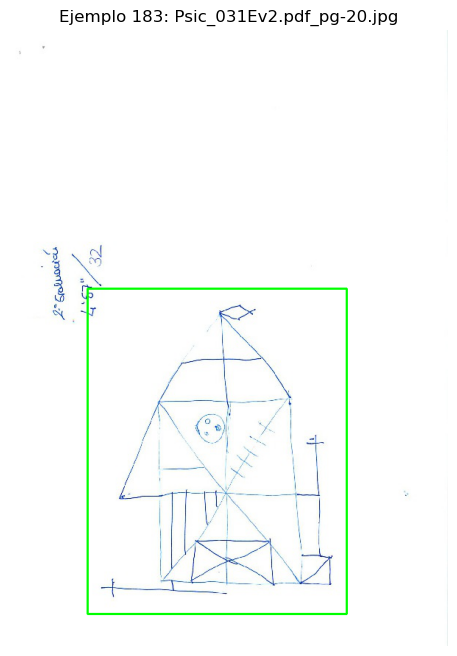

In [16]:
# Visualizar algunos ejemplos con bounding boxes
def mostrar_imagen_con_bbox(imagen, bbox, titulo=""):
    img_copy = imagen.copy()
    x, y, h, w = bbox
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Seleccionar algunos ejemplos aleatorios
n_ejemplos = 3
indices = random.sample(range(len(df_trazas_limpio)), n_ejemplos)

for i in indices:
    registro = df_trazas_limpio.iloc[i]
    ruta_img = os.path.join(path_imagenes_originales, registro['forig'])
    img = cv2.imread(ruta_img)
    
    if img is not None:
        bbox = [int(coord) for coord in registro['BB'].replace('[', '').replace(']', '').split(',')]
        mostrar_imagen_con_bbox(img, bbox, f"Ejemplo {i}: {registro['forig']}")